In [1]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.parameter import Parameter
from timeit import default_timer as tdt

from softadapt import SoftAdapt, NormalizedSoftAdapt, LossWeightedSoftAdapt

if torch.cuda.is_available():
    my_device = 'cuda'
else:
    my_device = 'cpu'

In [2]:
# Setup the domain
t_span = (0.0, 10.0)
x_span = (0.0, 10.0)
c = 1.0
alpha = 3.0

In [3]:
# Define h(x,t=0) = exp(-alpha*x^2)
#def h(x, alpha, period):
    # Map x to a [-period/2, period/2] interval using modulo operation
#    x_mod = (x + period / 2) % period - period / 2

    # Apply the Gaussian function to the modified x values
#    res = torch.exp(-alpha * x_mod**2)
    
#    return res
def h(x, alpha, period=0):
    res = torch.exp(-alpha * x**2)
    return res

Text(0.5, 0, 'x')

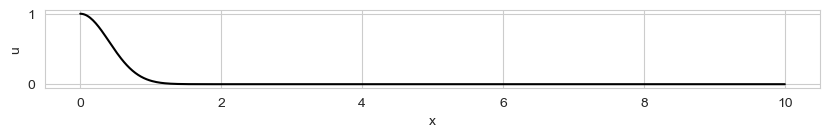

In [4]:
# Plot initial state
x_test = torch.linspace(x_span[0], x_span[1], 500)
u_init_test = h(x_test, alpha, x_span[1])
fig, ax = plt.subplots(1, 1, figsize=(10,3))
ax.plot(x_test, u_init_test, linestyle='-', color='k')
ax.set_aspect('equal')
ax.set_ylabel('u')
ax.set_xlabel('x')

In [5]:
# Define loss function
MSE_loss = torch.nn.MSELoss()

# Loss functions
def get_loss_PDE(x, t, net, c=0.5):
    # Calculate network solution at points [x,t] in the domain
    xt = torch.cat([x, t], dim=1)
    u_net = net(xt)

    # Calculate the derivates
    dudx = torch.autograd.grad(u_net, x, grad_outputs=torch.ones_like(u_net), create_graph=True)[0]
    dudt = torch.autograd.grad(u_net, t, grad_outputs=torch.ones_like(u_net), create_graph=True)[0]

    # Calculate PDE looss from M_PDE
    lhs = dudt
    rhs = -c * dudx

    # Calculate loss
    loss = MSE_loss(lhs, rhs)

    return loss

def get_loss_BC(x_bound, t, net):
    # x_bound is a tuple of floats
    xa = torch.tensor([x_bound[0]], device=my_device)
    u_bc = h(xa - c*t, alpha)

    # Calculate net response at times t on both boundaries. These should be the same for periodic boundary conditions.
    xa = xa.repeat(t.shape)
    xat = torch.cat([xa, t], dim=1)
    u_net_a = net(xat)

    # Calculate difference as MSE loss
    loss = MSE_loss(u_net_a, u_bc)

    return loss

def get_loss_IC(x, t0, net, h):
    t = torch.tensor([t0], device=my_device).repeat(x.shape)
    xt = torch.cat([x,t], dim=1)
    u_net = net(xt)

    # Calculate true initial conditions
    alpha = 3.0
    u_init = h(x, alpha)

    loss = MSE_loss(u_net, u_init)

    return loss

# Checking the initial conditions


In [6]:
# Define network
class FFN(nn.Module):
    def __init__(self, input_size, hidden_layers_size, output_size):
        super(FFN, self).__init__()
        
        n_layers = len(hidden_layers_size)
        HL = hidden_layers_size
        
        # Define layers
        self.L1 = nn.Linear(input_size, HL[0], bias=True)
        self.L2 = nn.Linear(HL[0], HL[1], bias=True)
        self.L3 = nn.Linear(HL[1], HL[2], bias=True)
        self.L4 = nn.Linear(HL[2], HL[3], bias=True)
        self.L5 = nn.Linear(HL[3], HL[-1], bias=True)
        #self.L6 = nn.Linear(HL[4], HL[5], bias=True)
        #self.L7 = nn.Linear(HL[5], HL[6], bias=True)
        #self.L8 = nn.Linear(HL[6], HL[-1], bias=True)
        self.output = nn.Linear(HL[-1], output_size, bias=True)
        
        # Define activation function
        self.act_fn = nn.Tanh()

    def forward(self, x):
        # Hidden layers
        x = self.act_fn(self.L1(x))
        x = self.act_fn(self.L2(x))
        x = self.act_fn(self.L3(x))
        x = self.act_fn(self.L4(x))
        x = self.act_fn(self.L5(x))
        #x = self.act_fn(self.L6(x))
        #x = self.act_fn(self.L7(x))
        #x = self.act_fn(self.L8(x))
        
        # Output layer
        x = self.output(x)
        
        return x

# Define network
#net = FFN(2, [64, 64, 64, 64, 64, 64, 64, 64], 1).to(my_device)
net = FFN(2, [32, 32, 32, 32, 32], 1).to(my_device)


In [7]:
# Test the network works
x_test = torch.rand(5, 1, requires_grad=True, device=my_device)
t_test = torch.rand(5, 1, requires_grad=True, device=my_device)
xt_test = torch.cat([x_test, t_test], dim=1)
u_test = net(xt_test)
print(u_test.flatten())

# Test the loss functions work
# PDE loss
PDE_loss = get_loss_PDE(x_test, t_test, net, c=c)
print(PDE_loss)
# Boundary condition loss
BC_loss = get_loss_BC(x_span, t_test, net)
print(BC_loss)
# Initial condition loss
IC_loss = get_loss_IC(x_test, t_span[0], net, h)
print(IC_loss)

tensor([0.0289, 0.0272, 0.0236, 0.0249, 0.0230], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.3273, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.1797, device='cuda:0', grad_fn=<MseLossBackward0>)


In [8]:
# Loss saving
loss_saved, PDE_loss_saved, BC_loss_saved, IC_loss_saved = [], [], [], []
adapt_PDE_loss_saved, adapt_BC_loss_saved, adapt_IC_loss_saved = [], [], []
epochs_saved = [0]

In [9]:
# Setup optimizer
learning_rate = 3e-4
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)

# SoftAdapt setup
softadapt_obj  = SoftAdapt(beta=0.1)
epochs_to_make_change = 5
adapt_weights = torch.tensor([1,1,1])    # Initial weighting of objects.


In [18]:
# Training setup
num_epochs = 1000
save_every_epochs = 100
batch_size = 256

loss1, loss2, loss3 = [], [], []
net = net.to(my_device)
# Train the model
for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()

    # Sample t, lambda in domain
    x_points = torch.rand(batch_size, 1, device=my_device, requires_grad=True) * x_span[1]
    t_points = torch.rand(batch_size, 1, device=my_device, requires_grad=True) * t_span[1]

    # Calculate PDE loss
    loss_PDE = get_loss_PDE(x_points, t_points, net, c=c)
    # Calculate BC loss
    loss_BC = get_loss_BC(x_span, t_points, net)
    # Calculate IC loss
    loss_IC = get_loss_IC(x_points, t_span[0], net, h)
    
    loss1.append( loss_PDE )
    loss2.append( loss_BC )
    loss3.append( loss_IC )

    # SoftAdapt
    if epoch % epochs_to_make_change == 0 and epoch != 0:
        adapt_weights = softadapt_obj.get_component_weights(torch.tensor(loss1),
                                                            torch.tensor(loss2),
                                                            torch.tensor(loss3),
                                                            verbose=False)
        loss1, loss2, loss3 = [], [], []
    
    loss = adapt_weights[0] * loss_PDE + adapt_weights[1] * loss_BC + adapt_weights[2] * loss_IC
    
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % save_every_epochs == 0 or epoch == 0:
        print(f"Epo {epoch+1:5d}, Loss: {loss.item():7.5f}, pde_loss: {loss_PDE:7.5f}, bc_loss: {loss_BC:7.5f}, " \
              f"ic_loss: {loss_IC:7.5f}" \
              f", aw[0]: {adapt_weights[0]:7.5f}, aw[1]: {adapt_weights[1]:7.5f}, aw[2]: {adapt_weights[2]:7.5f}")
        epochs_saved.append(epoch+1)
        loss_saved.append(loss.item())
        PDE_loss_saved.append(loss_PDE.detach().to('cpu'))
        BC_loss_saved.append(loss_BC.detach().to('cpu'))
        IC_loss_saved.append(loss_IC.detach().to('cpu'))
        adapt_PDE_loss_saved.append( adapt_weights[0]*loss_PDE.detach().to('cpu') )
        adapt_BC_loss_saved.append( adapt_weights[1]*loss_BC.detach().to('cpu') )
        adapt_IC_loss_saved.append( adapt_weights[2]*loss_IC.detach().to('cpu') )


Epo     1, Loss: 0.00042, pde_loss: 0.00088, bc_loss: 0.00029, ic_loss: 0.00008, aw[0]: 0.33336, aw[1]: 0.33331, aw[2]: 0.33333
Epo   100, Loss: 0.00033, pde_loss: 0.00069, bc_loss: 0.00025, ic_loss: 0.00005, aw[0]: 0.33336, aw[1]: 0.33331, aw[2]: 0.33332
Epo   200, Loss: 0.00045, pde_loss: 0.00106, bc_loss: 0.00025, ic_loss: 0.00004, aw[0]: 0.33328, aw[1]: 0.33337, aw[2]: 0.33336
Epo   300, Loss: 0.00028, pde_loss: 0.00058, bc_loss: 0.00025, ic_loss: 0.00002, aw[0]: 0.33333, aw[1]: 0.33333, aw[2]: 0.33334
Epo   400, Loss: 0.00037, pde_loss: 0.00086, bc_loss: 0.00022, ic_loss: 0.00003, aw[0]: 0.33331, aw[1]: 0.33335, aw[2]: 0.33334
Epo   500, Loss: 0.00033, pde_loss: 0.00063, bc_loss: 0.00033, ic_loss: 0.00004, aw[0]: 0.33331, aw[1]: 0.33334, aw[2]: 0.33335
Epo   600, Loss: 0.00020, pde_loss: 0.00039, bc_loss: 0.00020, ic_loss: 0.00002, aw[0]: 0.33336, aw[1]: 0.33333, aw[2]: 0.33332
Epo   700, Loss: 0.00024, pde_loss: 0.00053, bc_loss: 0.00018, ic_loss: 0.00001, aw[0]: 0.33332, aw[1]: 

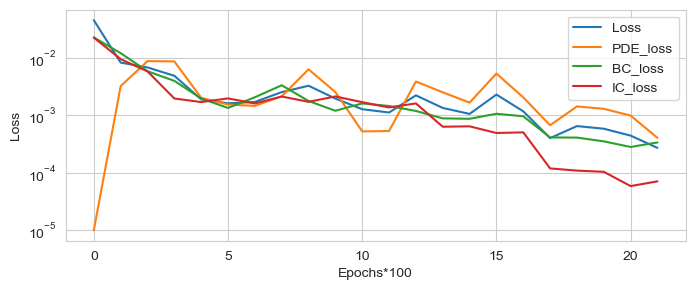

In [17]:
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(8,3))
ax.plot(loss_saved, label='Loss')
ax.plot(PDE_loss_saved, label='PDE_loss')
ax.plot(BC_loss_saved, label='BC_loss')
ax.plot(IC_loss_saved, label='IC_loss')
ax.set_xlabel(f'Epochs*{save_every_epochs}')
ax.set_ylabel('Loss')
ax.legend()
ax.set_yscale('log')

MovieWriter ffmpeg unavailable; using Pillow instead.


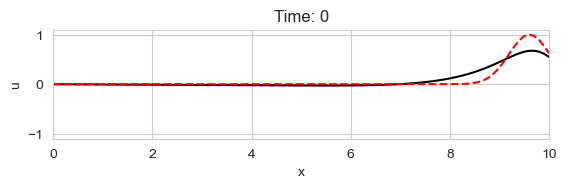

In [19]:
# Displaying solution
from matplotlib.animation import FuncAnimation
from functools import partial

net.to('cpu')

t_display = torch.linspace(t_span[0], t_span[1], 100)
x_display = torch.linspace(x_span[0], x_span[1], 100)

fig, ax = plt.subplots()

def init_ani():
    line1, = ax.plot([], [], color='k')
    line2, = ax.plot([], [], color='red', linestyle='--')
    ax.set_xlim(x_span[0], x_span[1])
    ax.set_ylim(-1.1, 1.1)
    ax.set_aspect('equal')
    ax.set_ylabel('u')
    ax.set_xlabel('x')
    ax.set_title(f'Time: {0}')
    return line1, line2
line1, line2, = init_ani()

def update(frame, line1, line2, x):
    x = x.view(-1,1)
    t = frame/2.5 * torch.ones_like(x)
    xt = torch.cat([x, t], dim=1)
    u = net(xt)
    line1.set_data(x.flatten().detach().numpy(), u.detach().numpy())
    u_exact = h( x_display-c*t[0], alpha, x_span[1] )
    line2.set_data(x.flatten().detach().numpy(), u_exact)
    ax.set_title(f'Time: {frame/2.5}')
    return line1, line2

#update(5, line1, x_display)
#my_partial = partial(update, line=line1, x=x_display)
#my_partial(5)


ani = FuncAnimation(fig, partial(update, line1=line1, line2=line2, x=x_display), init_func=init_ani, frames=25, interval=0.1)
ani.save('./test_ani.gif')

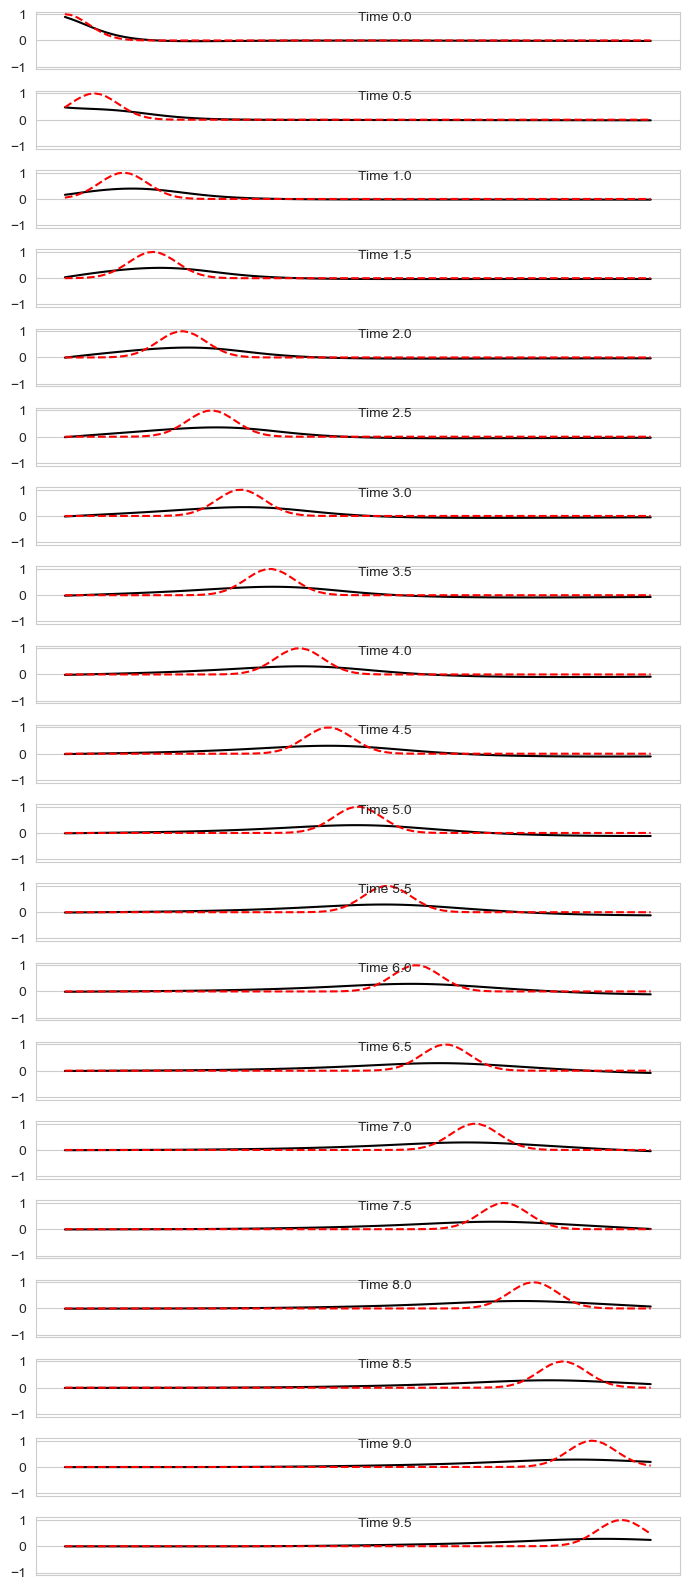

In [13]:
# Plot initial state
fig, ax = plt.subplots(20, 1, figsize=(7,16))
fig.subplots_adjust(hspace=0.0)

net = net.to('cpu')

# Initial state
def get_res_at_time(t, x_display):
    t = torch.FloatTensor([t]).repeat(x_display.shape)
    xt = torch.cat([x_display.view(-1,1), t.view(-1,1)], dim=1)
    res = net(xt)
    return res.flatten().detach().numpy()

t_test = np.arange(0, 10, 0.5)

for i in range(len(t_test)):
    # Get network solution
    t = t_test[i]
    u_net = get_res_at_time(t, x_display)
    ax[i].plot(x_display, u_net, color='k', label='net')
    ax[i].set_ylim(-1.1, 1.1)
    ax[i].text(5.0, 0.75, f'Time {t}')
    
    # Get exact solution 
    u_exact = h( x_display-c*t, alpha, x_span[1] )
    ax[i].plot(x_display, u_exact, color='red', linestyle='--', label='Exact')

    ax[i].set_xticks([])
    
plt.tight_layout()
          